# Disease Prediction from Symptoms Analysis

This notebook performs comprehensive analysis and modeling for disease prediction based on symptoms.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Analysis

In [5]:
# Load the datasets
data_path = 'D:\External_Projects\shivanand_mca\data\disease_symptom_data'
df = pd.read_csv(os.path.join(data_path, 'dataset.csv'))
severity_df = pd.read_csv(os.path.join(data_path, 'Symptom-severity.csv'))
description_df = pd.read_csv(os.path.join(data_path, 'symptom_Description.csv'))

# Display basic information
print("Dataset Shape:", df.shape)
print("\nNumber of unique diseases:", df['Disease'].nunique())
print("\nSample diseases:", df['Disease'].unique()[:5])

# Analyze symptoms distribution
symptoms_cols = df.columns[1:]
all_symptoms = df[symptoms_cols].values.ravel()
unique_symptoms = pd.Series([x for x in all_symptoms if pd.notna(x)]).unique()
print("\nTotal unique symptoms:", len(unique_symptoms))

Dataset Shape: (4920, 18)

Number of unique diseases: 41

Sample diseases: ['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction']

Total unique symptoms: 131


## 2. Data Preprocessing and Feature Engineering

In [6]:
def preprocess_data(df, severity_df):
    # Create symptom severity dictionary
    severity_dict = dict(zip(severity_df['Symptom'], severity_df['weight']))
    
    # Create feature matrix
    symptoms = df.columns[1:]
    X = df[symptoms]
    y = df['Disease']
    
    # Replace NaN with 0 and other values with 1 (presence of symptom)
    X = X.fillna(0)
    X = X.apply(lambda x: x.map(lambda x: 1 if isinstance(x, str) else 0))
    
    # Add severity features
    severity_features = []
    for _, row in X.iterrows():
        severity = 0
        for symptom in symptoms:
            if row[symptom] == 1:
                if symptom.strip() in severity_dict:
                    severity += severity_dict[symptom.strip()]
        severity_features.append(severity)
    
    X['symptom_severity'] = severity_features
    
    # Encode disease labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    return X, y, le

# Preprocess the data
X, y, label_encoder = preprocess_data(df, severity_df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Model Training and Evaluation

In [7]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Save the model
    model_save_path = os.path.join('..', 'models', f'disease-pred-by-symptoms_{model_name}.pkl')
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    import joblib
    joblib.dump(model, model_save_path)
    
    return {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'report': report
    }

# Train multiple models
models = {
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'svm': SVC(kernel='rbf', random_state=42),
    'xgboost': XGBClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = train_evaluate_model(model, X_train, X_test, y_train, y_test, name)

Training random_forest...
Training gradient_boosting...
Training svm...
Training xgboost...


## 4. Neural Network Model

In [ ]:
def create_nn_model(input_dim, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train neural network
nn_model = create_nn_model(X_train.shape[1], len(np.unique(y)))
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Save the neural network model
nn_save_path = os.path.join('D:\External_Projects\shivanand_mca', 'models', 'disease-pred-by-symptoms_neural_network')
nn_model.save(nn_save_path)

# Evaluate neural network
nn_eval = nn_model.evaluate(X_test, y_test)
results['neural_network'] = {
    'accuracy': nn_eval[1],
    'cv_mean': np.mean(history.history['val_accuracy']),
    'cv_std': np.std(history.history['val_accuracy'])
}

## 5. Results Visualization and Comparison

Model Comparison:
               Model  Test Accuracy  CV Mean Accuracy    CV Std
0      random_forest       0.180894          0.213414  0.001079
1  gradient_boosting       0.180894          0.213414  0.001761
3            xgboost       0.180894          0.211127  0.005950
2                svm       0.172764          0.217226  0.004918


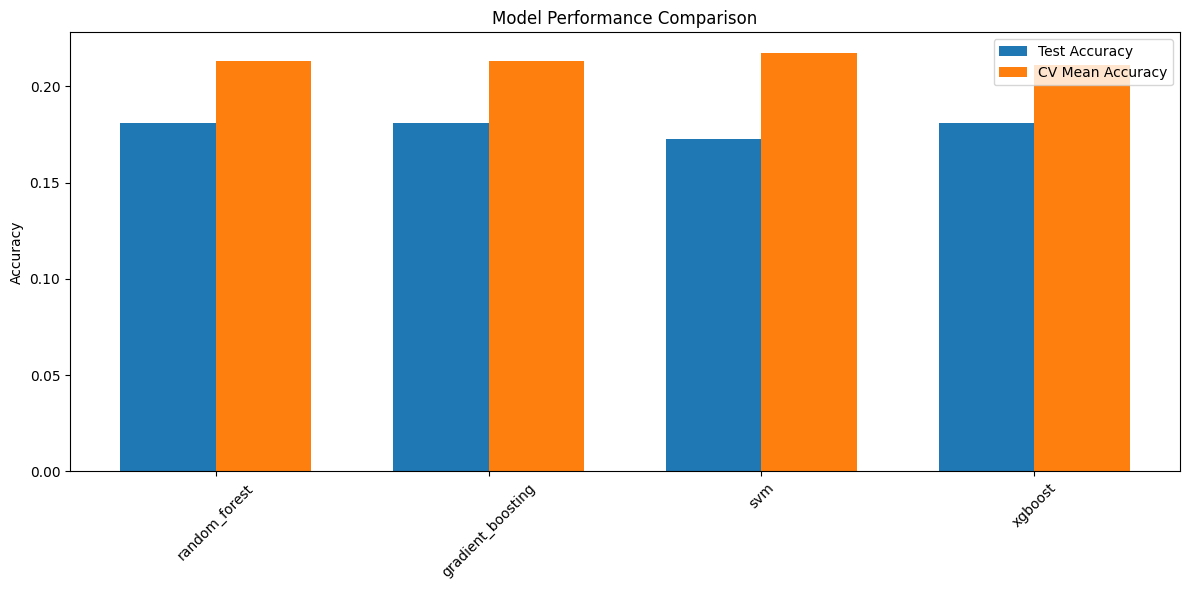

In [10]:
def plot_model_comparison(results):
    models = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in models]
    cv_means = [results[m]['cv_mean'] for m in models]
    cv_stds = [results[m]['cv_std'] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, accuracies, width, label='Test Accuracy')
    rects2 = ax.bar(x + width/2, cv_means, width, label='CV Mean Accuracy')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'CV Mean Accuracy': [results[m]['cv_mean'] for m in results],
    'CV Std': [results[m]['cv_std'] for m in results]
})

print("Model Comparison:")
print(comparison_df.sort_values('Test Accuracy', ascending=False))

# Plot comparison
plot_model_comparison(results)